In [1]:
# 0. Requisitos e instalación
!pip install -q jiwer soundfile tensorflow-io


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 42.2 MB/s eta 0:00:00


In [2]:
# 0.1

!pip install tqdm
from tqdm import tqdm


In [3]:
# 1. Montar Google Drive y comprobar ruta
from google.colab import drive
drive.mount('/content/drive')

AUDIO_DIR = "/content/drive/MyDrive/audios"
MODEL_DIR = AUDIO_DIR + "/model_ctc"
import os
os.makedirs(MODEL_DIR, exist_ok=True)
print("AUDIO_DIR =", AUDIO_DIR)
print("MODEL_DIR =", MODEL_DIR)


Mounted at /content/drive
AUDIO_DIR = /content/drive/MyDrive/audios
MODEL_DIR = /content/drive/MyDrive/audios/model_ctc


In [4]:
# 2. Paquetes
import tensorflow as tf
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import subprocess
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
from jiwer import wer, mer, cer


In [5]:
# 3. Leer validated.tsv y filtrar archivos existentes en Drive
# Ajusta la ruta si tu validated.tsv está en otra ubicación dentro de Drive
TSV_PATH = os.path.join(AUDIO_DIR, "validated.tsv")
df = pd.read_csv(TSV_PATH, sep="\t", keep_default_na=False)
df = df[['path','sentence']].copy()
df['audio_path'] = df['path'].apply(lambda p: os.path.join(AUDIO_DIR, p))
df = df[df['audio_path'].apply(os.path.exists)].reset_index(drop=True)
print("Registros encontrados con audio existente:", len(df))
df.head()


Registros encontrados con audio existente: 6672


,path,sentence,audio_path
0,common_voice_es_19600147.mp3,"En los años que siguieron, este trabajo Espart...",/content/drive/MyDrive/audios/common_voice_es_...
1,common_voice_es_20287154.mp3,Cursó estudios escolares en su ciudad natal y ...,/content/drive/MyDrive/audios/common_voice_es_...
2,common_voice_es_19599359.mp3,Este asesinato sucedía una noche sin luna y mu...,/content/drive/MyDrive/audios/common_voice_es_...
3,common_voice_es_19626710.mp3,"Al morir, tras seis a ocho meses de vida, se l...",/content/drive/MyDrive/audios/common_voice_es_...
4,common_voice_es_19688848.mp3,Se desconoce el criterio de selección seguido ...,/content/drive/MyDrive/audios/common_voice_es_...


In [6]:
# 4. Convertir mp3 a wav 16k mono si es necesario (usa ffmpeg)
def convert_to_wav16k(in_path, out_path):
    if os.path.exists(out_path):
        return out_path
    cmd = [
        "ffmpeg", "-y", "-i", in_path,
        "-ac", "1", "-ar", "16000", "-vn", out_path
    ]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    return out_path

wav_dir = os.path.join(AUDIO_DIR, "wavs")
os.makedirs(wav_dir, exist_ok=True)
df['wav_path'] = df['audio_path'].apply(lambda p: os.path.join(wav_dir, Path(p).stem + ".wav"))

# Usar tqdm para mostrar progreso
from tqdm import tqdm
for in_p, out_p in tqdm(zip(df['audio_path'], df['wav_path']), total=len(df), desc="Convirtiendo audios"):
    convert_to_wav16k(in_p, out_p)
print("Conversión completada (skip si ya existía).")


Convirtiendo audios: 100%|██████████| 6672/6672 [00:01<00:00, 6096.09it/s]

Conversión completada (skip si ya existía).


In [7]:
# 5. Tokenización (carácter a índice)
# Lowercase básico y mantener caracteres frecuentes en español
chars = list("abcdefghijklmnopqrstuvwxyzñáéíóúü'.,?¡! ")  # incluir espacio
char_to_idx = {c:i+1 for i,c in enumerate(chars)}  # 0 reservar para blank / padding
idx_to_char = {i:c for c,i in char_to_idx.items()}
vocab_size = len(char_to_idx) + 1
print("Vocab size:", vocab_size)


Vocab size: 41


In [8]:
# 6. Preprocesamiento de audio -> log-mel (funciones)
SR = 16000
N_FFT = 512
HOP_LENGTH = 160
N_MELS = 80
MAX_AUDIO_SECONDS = 8.0
MAX_FRAMES = int(np.ceil((MAX_AUDIO_SECONDS * SR - N_FFT) / HOP_LENGTH)) + 1

def load_wav(path, sr=SR):
    x, _ = librosa.load(path, sr=sr)
    if x.shape[0] > sr*MAX_AUDIO_SECONDS:
        x = x[:int(sr*MAX_AUDIO_SECONDS)]
    return x

def wav_to_log_mel(x):
    S = librosa.feature.melspectrogram(y=x, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
    S_db = librosa.power_to_db(S, ref=np.max)
    S_db = (S_db + 80.0) / 80.0  # normalizar a ~[0,1]
    return S_db.T  # frames x mel


In [9]:
# 7. Codificar transcripción y pad
def text_to_labels(text):
    text = text.lower().strip()
    res = []
    for ch in text:
        if ch in char_to_idx:
            res.append(char_to_idx[ch])
    return np.array(res, dtype=np.int32)

def pad_labels(labels, maxlen):
    out = np.zeros((maxlen,), dtype=np.int32)
    out[:len(labels)] = labels
    return out


In [10]:
# 8. Crear archivo intermedio de features (CPU forzado aquí)
FEATURES_DIR = os.path.join(AUDIO_DIR, "features_np")
os.makedirs(FEATURES_DIR, exist_ok=True)

examples = []
max_label_len = 0
# Forzar CPU: todo este bloque se ejecuta en CPU aunque el runtime tenga GPU
with tf.device("/CPU:0"):
    for i, row in df.iterrows():
        wav = row['wav_path']
        x = load_wav(wav)
        feat = wav_to_log_mel(x)
        feat_path = os.path.join(FEATURES_DIR, Path(wav).stem + ".npy")
        np.save(feat_path, feat)
        labels = text_to_labels(row['sentence'])
        max_label_len = max(max_label_len, len(labels))
        examples.append({"feat": feat_path, "label": labels, "text": row['sentence']})

print("Ejemplos:", len(examples), "Max label len:", max_label_len)


Ejemplos: 6672 Max label len: 140


In [11]:
# 9. Construir dataset TensorFlow optimizado para GPU (sin tf.py_function)
BATCH_SIZE = 32  # Aumentado de 8 a 32 para mejor rendimiento en GPU

print("Cargando features en memoria...")
all_features = []
all_labels = []
for i, ex in enumerate(examples):
    feat = np.load(ex["feat"]).astype(np.float32)
    label = ex["label"].astype(np.int32)
    all_features.append(feat)
    all_labels.append(label)

print("Creando datasets optimizados...")

# Dividir datos primero
dataset_size = len(all_features)
train_size = int(dataset_size * 0.8)

train_features = all_features[:train_size]
train_labels = all_labels[:train_size]
val_features = all_features[train_size:]
val_labels = all_labels[train_size:]

# Crear datasets con from_generator (evita tf.py_function)
def gen_train():
    """Generador para datos de entrenamiento"""
    indices = np.arange(len(train_features))
    np.random.shuffle(indices)
    for idx in indices:
        yield train_features[idx], train_labels[idx]

def gen_val():
    """Generador para datos de validación"""
    for idx in range(len(val_features)):
        yield val_features[idx], val_labels[idx]

# Construir pipeline de entrenamiento
train_ds = tf.data.Dataset.from_generator(
    gen_train,
    output_signature=(
        tf.TensorSpec(shape=(None, 80), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).filter(
    lambda x, y: tf.shape(x)[0] > 10
).padded_batch(
    BATCH_SIZE,
    padded_shapes=([None, 80], [None]),
    padding_values=(0.0, 0)
).map(
    lambda x, y: {
        "inputs": x,
        "input_length": tf.reduce_sum(tf.cast(tf.reduce_any(tf.not_equal(x, 0.0), axis=-1), tf.int32), axis=1),
        "labels": y,
        "label_length": tf.reduce_sum(tf.cast(tf.not_equal(y, 0), tf.int32), axis=1)
    }
).prefetch(tf.data.AUTOTUNE)

# Construir pipeline de validación
val_ds = tf.data.Dataset.from_generator(
    gen_val,
    output_signature=(
        tf.TensorSpec(shape=(None, 80), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).filter(
    lambda x, y: tf.shape(x)[0] > 10
).padded_batch(
    BATCH_SIZE,
    padded_shapes=([None, 80], [None]),
    padding_values=(0.0, 0)
).map(
    lambda x, y: {
        "inputs": x,
        "input_length": tf.reduce_sum(tf.cast(tf.reduce_any(tf.not_equal(x, 0.0), axis=-1), tf.int32), axis=1),
        "labels": y,
        "label_length": tf.reduce_sum(tf.cast(tf.not_equal(y, 0), tf.int32), axis=1)
    }
).prefetch(tf.data.AUTOTUNE)

print("✓ Dataset optimizado listo (SIN tf.py_function - GPU activa)")
print(f"✓ BATCH_SIZE: {BATCH_SIZE} (optimizado para GPU)")
print(f"Total ejemplos: {dataset_size}")
print(f"Entrenamiento: {len(train_features)}, Validación: {len(val_features)}")


Cargando features en memoria...
Creando datasets optimizados...
✓ Dataset optimizado listo (SIN tf.py_function - GPU activa)
✓ BATCH_SIZE: 32 (optimizado para GPU)
Total ejemplos: 6672
Entrenamiento: 5337, Validación: 1335


In [12]:
# 10. Modelo CTC (Keras functional)
# IMPORTANTE: Forzar N_MELS = 80 (puede haber sido modificado)
N_MELS = 80
print(f"N_MELS forzado a: {N_MELS}")

def ctc_model(input_dim=(MAX_FRAMES, N_MELS), rnn_units=256):
    print(f"Creando modelo con N_MELS={N_MELS}, vocab_size={vocab_size}")
    inp = tf.keras.layers.Input(shape=(None, N_MELS), name='inputs')
    x = tf.keras.layers.LayerNormalization()(inp)
    x = tf.keras.layers.Conv1D(256, 11, strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv1D(256, 11, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_units, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_units, return_sequences=True))(x)
    logits = tf.keras.layers.Dense(vocab_size, name='logits')(x)
    return tf.keras.Model(inputs=inp, outputs=logits, name='ctc_model')

# Eliminar modelo anterior si existe
if 'model' in globals():
    del model

model = ctc_model()
model.summary(line_length=120)


N_MELS forzado a: 80
Creando modelo con N_MELS=80, vocab_size=41


Model: "ctc_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ inputs (InputLayer)                                 │ (None, None, 80)                       │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ layer_normalization (LayerNormalization)            │ (None, None, 80)                       │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv1d (Conv1D)                                     │ (None, None, 256)                      │               225,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv1d_1 (Conv1D)                                   │ (None, None, 256)                      │               721,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dropout (Dropout)                                   │ (None, None, 256)                      │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ bidirectional (Bidirectional)                       │ (None, None, 512)                      │               789,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ bidirectional_1 (Bidirectional)                     │ (None, None, 512)                      │             1,182,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ logits (Dense)                                      │ (None, None, 41)                       │                21,
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 2,940,105 (11.22 MB)

 Trainable params: 2,940,105 (11.22 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# 11. CTC loss wrapper and training step via custom training loop (safer para shapes variables)
optimizer = tf.keras.optimizers.Adam(1e-4)

# Definir métricas
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')

@tf.function(reduce_retracing=True)
def ctc_loss_fn(logits, labels, logit_length, label_length):
    logit_length = tf.cast(logit_length, tf.int32)
    label_length = tf.cast(label_length, tf.int32)
    loss = tf.nn.ctc_loss(
        labels=labels,
        logits=logits,
        label_length=label_length,
        logit_length=logit_length,
        logits_time_major=False,
        blank_index=0
    )
    return tf.reduce_mean(loss)


In [14]:
# 12. Helper para decodificar (greedy)
def greedy_decode(logits, logit_lengths):
    decoded = tf.nn.ctc_greedy_decoder(tf.transpose(logits, [1,0,2]), sequence_length=logit_lengths)[0][0]
    dense = tf.sparse.to_dense(decoded, default_value=0).numpy()
    texts = []
    for row in dense:
        s = ""
        for idx in row:
            if idx==0: continue
            s += idx_to_char.get(int(idx), '')
        texts.append(s)
    return texts


In [15]:
#13. Training loop con tqdm y guardado del mejor modelo
from tqdm import tqdm
import os

EPOCHS = 15
best_val = 1e9
history = {"loss":[], "val_loss":[]}

for epoch in range(1, EPOCHS+1):

    print(f"\n--- Epoch {epoch}/{EPOCHS} ---")
    train_loss.reset_state()

    # Barra de progreso para entrenamiento
    for batch in tqdm(train_ds, desc="Entrenando", leave=False):
        x = batch['inputs']
        labels = batch['labels']
        input_len = tf.reduce_sum(tf.cast(tf.reduce_any(tf.not_equal(x,0.0), axis=-1), tf.int32), axis=1)

        with tf.GradientTape() as tape:
            logits = model(x, training=True)
            logit_len = input_len // 1
            loss = ctc_loss_fn(logits, labels, logit_len, batch['label_length'])

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_loss.update_state(loss)

    # Validación con tqdm (opcional)
    val_loss.reset_state()
    for batch in tqdm(val_ds, desc="Validando", leave=False):
        x = batch['inputs']
        labels = batch['labels']
        input_len = tf.reduce_sum(tf.cast(tf.reduce_any(tf.not_equal(x,0.0), axis=-1), tf.int32), axis=1)

        logits = model(x, training=False)
        logit_len = input_len // 1
        vloss = ctc_loss_fn(logits, labels, logit_len, batch['label_length'])
        val_loss.update_state(vloss)

    h_loss = float(train_loss.result().numpy())
    h_vloss = float(val_loss.result().numpy())

    history['loss'].append(h_loss)
    history['val_loss'].append(h_vloss)

    print(f"Epoch {epoch}/{EPOCHS}  loss={h_loss:.4f}  val_loss={h_vloss:.4f}")

    # 🔥 Guardar mejor modelo en formato Keras
    save_path = os.path.join(MODEL_DIR, "best_model.keras")

    if h_vloss < best_val:
        best_val = h_vloss
        model.save(save_path, include_optimizer=False)
        print(f"Modelo guardado (mejor val_loss): {save_path}")



--- Epoch 1/15 ---


Epoch 1/15  loss=278.2939  val_loss=264.0838
Modelo guardado (mejor val_loss): /content/drive/MyDrive/audios/model_ctc/best_model.keras

--- Epoch 2/15 ---


Epoch 2/15  loss=234.2000  val_loss=257.8102
Modelo guardado (mejor val_loss): /content/drive/MyDrive/audios/model_ctc/best_model.keras

--- Epoch 3/15 ---


Epoch 3/15  loss=225.5500  val_loss=244.6118
Modelo guardado (mejor val_loss): /content/drive/MyDrive/audios/model_ctc/best_model.keras

--- Epoch 4/15 ---


Epoch 4/15  loss=209.0413  val_loss=223.8296
Modelo guardado (mejor val_loss): /content/drive/MyDrive/audios/model_ctc/best_model.keras

--- Epoch 5/15 ---


Epoch 5/15  loss=193.1698  val_loss=209.6222
Modelo guardado (mejor val_loss): /content/drive/MyDrive/audios/model_ctc/best_model.keras

--- Epoch 6/15 ---


Epoch 6/15  loss=182.0760  val_loss=199.7204
Modelo guardado (mejor val_loss): /content/drive/MyDrive/audios/model_ctc/best_model.keras

--- Epoch 7/15 ---


Epoch 7/15  loss=173.1581  val_loss=190.4703
Modelo guardado (mejor val_loss): /content/drive/MyDrive/audios/model_ctc/best_model.keras

--- Epoch 8/15 ---


Epoch 8/15  loss=165.4022  val_loss=183.3537
Modelo guardado (mejor val_loss): /content/drive/MyDrive/audios/model_ctc/best_model.keras

--- Epoch 9/15 ---


Epoch 9/15  loss=158.9762  val_loss=176.3632
Modelo guardado (mejor val_loss): /content/drive/MyDrive/audios/model_ctc/best_model.keras

--- Epoch 10/15 ---


Epoch 10/15  loss=153.3395  val_loss=170.5366
Modelo guardado (mejor val_loss): /content/drive/MyDrive/audios/model_ctc/best_model.keras

--- Epoch 11/15 ---


Epoch 11/15  loss=148.2654  val_loss=165.9055
Modelo guardado (mejor val_loss): /content/drive/MyDrive/audios/model_ctc/best_model.keras

--- Epoch 12/15 ---


Epoch 12/15  loss=143.9757  val_loss=162.0448
Modelo guardado (mejor val_loss): /content/drive/MyDrive/audios/model_ctc/best_model.keras

--- Epoch 13/15 ---


Epoch 13/15  loss=139.7939  val_loss=158.6265
Modelo guardado (mejor val_loss): /content/drive/MyDrive/audios/model_ctc/best_model.keras

--- Epoch 14/15 ---


Epoch 14/15  loss=136.0972  val_loss=156.6333
Modelo guardado (mejor val_loss): /content/drive/MyDrive/audios/model_ctc/best_model.keras

--- Epoch 15/15 ---


Epoch 15/15  loss=132.8248  val_loss=153.8614
Modelo guardado (mejor val_loss): /content/drive/MyDrive/audios/model_ctc/best_model.keras


In [16]:
# 14. Guardar historial y modelo final
import json
with open(os.path.join(MODEL_DIR, "training_history.json"), "w") as f:
    json.dump(history, f)
model.save(os.path.join(MODEL_DIR, "final_model.keras"), include_optimizer=False)
print("Modelo final guardado.")


Modelo final guardado.


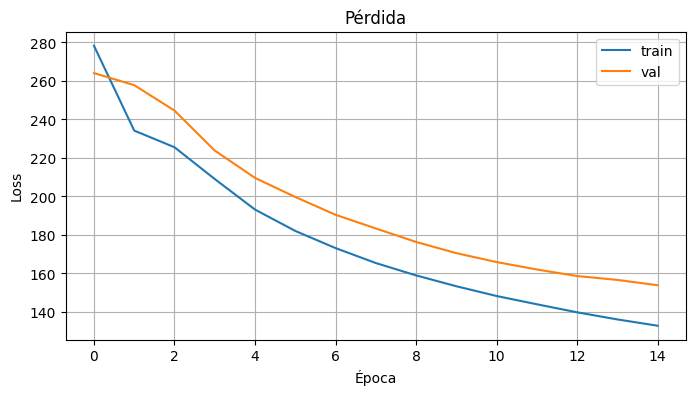

GT: Areola no fue titular indiscutible, solo jugó un partido por temporada.
PRED: ariolaofueitularidicotsooetatiuo
----------------------------------------
GT: Posteriormente a la Guerra civil su uso se limitó al distrito de Deusto.
PRED: odeortecanatrasiviuuosemitoadiscitoedeusto
----------------------------------------
GT: Sus habitantes participaron de la Batalla de los Campos del Pelennor.
PRED: suscaitantesociparodrataatmuoscaposeperema
----------------------------------------
GT: El pico es negruzco, excepto el tercio basal que es amarillo a anaranjado opaco.
PRED: eltecoemegooscoesetoepecióvasaeesamarioaaadop
----------------------------------------
GT: La temporada siguiente fue transferido al Fabriano, repitiendo sus buenas actuaciones del año anterior.
PRED: laecoraasiientecocasprerefofabaoepetiendosusponasatatienesonaantei
----------------------------------------
GT: El León logró consagrarse campeón y subir a la Primera División.
PRED: edolorogoaeaelaperudeaaadco
----------

In [17]:
# 15. Gráficas: pérdida y ejemplos de predicción
plt.figure(figsize=(8,4))
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.title("Pérdida")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Usar el modelo en memoria (ya tiene las dimensiones correctas)
# ejemplos
def predict_examples(n=6):
    samples = np.random.choice(len(examples), size=min(n, len(examples)), replace=False)
    for i in samples:
        feat = np.load(examples[i]['feat'])  # shape: (frames, 80)
        lab = examples[i]['label']
        # Agregar dimensión batch correctamente
        logits = model.predict(feat[np.newaxis, :, :], verbose=0)  # (1, frames, vocab_size)
        # La longitud de logits se reduce por el stride=2 del primer Conv1D
        logit_len = feat.shape[0] // 2
        # input_len debe ser tensor de TensorFlow con la longitud de frames después del stride
        input_len = tf.constant([logit_len], dtype=tf.int32)
        pred = greedy_decode(logits, input_len)[0]
        print("GT:", examples[i]['text'])
        print("PRED:", pred)
        print("-"*40)

predict_examples(6)


In [18]:
# 16. Métricas CER/WER en conjunto de validación (ejemplo rápido)
all_gt = []
all_pred = []
for batch in val_ds:
    x = batch['inputs'].numpy()
    # Calcular la longitud después del stride=2 del primer Conv1D
    input_len = np.sum(np.any(x!=0.0, axis=-1), axis=1) // 2
    logits = model.predict(x, verbose=0)
    preds = greedy_decode(logits, tf.constant(input_len, dtype=tf.int32))
    for i in range(len(preds)):
        gt = "".join([idx_to_char.get(int(c), "") for c in batch['labels'][i].numpy() if c!=0])
        all_gt.append(gt)
        all_pred.append(preds[i])

print(f"\nTotal ejemplos evaluados: {len(all_gt)}")
print("\n--- Primeras 5 predicciones ---")
for i in range(min(5, len(all_gt))):
    print(f"GT:   {all_gt[i]}")
    print(f"PRED: {all_pred[i]}")
    print("-"*50)

print("\nCER:", cer(all_gt, all_pred))
print("WER:", wer(all_gt, all_pred))



Total ejemplos evaluados: 1335

--- Primeras 5 predicciones ---
GT:   oigo la voz melosa de aquellas criollas ataviadas con graciosa ingenuidad de estatuas clásicas
PRED: oegoladoelasapapeafiiasataniadacondraciosaegerinadetatra
--------------------------------------------------
GT:   albo hipil recamado con sedas de colores, vestidura indígena semejante a una tunicela antigua
PRED: alpoitilrecamadgonceladeconloredetiuraidienaem
--------------------------------------------------
GT:   nunca más apareció en espectáculos televisivos como the computer chronicle donde fungía como coanfitrión.
PRED: tasopresieretoseismondedecictoudesuciodloconese
--------------------------------------------------
GT:   sitios arenosos abiertos, campos húmedos, barbechos, marismas, playas, sitios removidos y bordes de caminos.
PRED: iesarenosulaitaposubeosmaveosmarisaslaassitoregoiosyvortesdeo
--------------------------------------------------
GT:   otros efectos, como reacciones de hipersensibilidad y desór

In [19]:
# 17. Verificar que el modelo tiene las dimensiones correctas
print("Verificando dimensiones del modelo en memoria...")
if 'model' in globals():
    try:
        # Probar con datos de validación
        test_batch = next(iter(val_ds))
        test_x = test_batch['inputs']
        print(f"Shape de datos de prueba: {test_x.shape}")
        test_logits = model(test_x[:1], training=False)
        print(f"Shape de logits de salida: {test_logits.shape}")
        print("✓ Modelo en memoria es compatible con los datos (N_MELS=80)")
    except Exception as e:
        print(f"✗ ERROR: Modelo incompatible - {e}")
        print("\n⚠️ SOLUCIÓN: Debes volver a entrenar el modelo:")
        print("   1. Ejecuta celda 10 (crear modelo con N_MELS=80)")
        print("   2. Ejecuta celda 11 (definir loss)")
        print("   3. Ejecuta celda 13 (entrenar 30 épocas)")
        print("   4. El modelo guardado tendrá las dimensiones correctas")
else:
    print("No hay modelo en memoria. Ejecuta celda 10 para crear el modelo.")


Verificando dimensiones del modelo en memoria...
Shape de datos de prueba: (32, 801, 80)
Shape de logits de salida: (1, 401, 41)
✓ Modelo en memoria es compatible con los datos (N_MELS=80)


In [20]:
# 2.1 VERIFICAR GPU - CRÍTICO para debugging
print("="*60)
print("VERIFICACIÓN DE DISPOSITIVOS GPU/CPU")
print("="*60)
gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')
print(f"✓ GPUs detectadas: {len(gpus)}")
for gpu in gpus:
    print(f"  - {gpu}")
print(f"✓ CPUs detectadas: {len(cpus)}")
if len(gpus) == 0:
    print("⚠️  ADVERTENCIA: No se detectó GPU. Ve a Runtime > Change Runtime Type > GPU")
print("="*60)


VERIFICACIÓN DE DISPOSITIVOS GPU/CPU
✓ GPUs detectadas: 1
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
✓ CPUs detectadas: 1
